In [5]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install sklearn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 11.5 MB 1.7 MB/s            
     |████████████████████████████████| 503 kB 27.3 MB/s            
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.co

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gdown
import re
import time
import os

%matplotlib inline

In [16]:
gdown.download('https://storage.googleapis.com/datasets_ai/Bas%D0%B5Unit/6_Text/clean_data.csv', None, quiet = True)

'clean_data.csv'

In [17]:
!ls

Text_Classifier2.ipynb clean_data.csv


In [79]:
df = pd.read_csv('clean_data.csv')

In [80]:
df

,text,category,theme
0,Здравствуйте. Подскажите пожалуйста можно ли с...,Дороги и транспорт,Запрос на льготы / субсидии
1,Подскажите пожалуйста имеют ли право не платит...,ЖКХ,Запрос юридической консультации
2,""" Спасибо Вам огромное за возобновление строит...",Строительство,Запрос юридической консультации
3,Проблема одна и общая стала в городе. Спорт. у...,Спорт,Недовольство общее
4,Некоторое время назад для школьников и студент...,Дороги и транспорт,Запрос на льготы / субсидии
...,...,...,...
10054,Единственная асфальтированная дорога в п. Заре...,Благо­­устрой­­ство,NaN
10055,УВАЖАЕМЫЙ ИГОРЬ ГЕОРГИЕВИЧ! В ПОСЕЛКЕ ЛЕВ ТОЛС...,Борьба с коррупцией,NaN
10056,Здравствуйте! 19 июня 2019 года затопило магаз...,ЖКХ,NaN
10057,Уважаемый! Помогите пожалуйста решить проблему...,ЖКХ,NaN


In [81]:
print(df.shape)

(10059, 3)


In [82]:
print(df.isnull().sum())

text           0
category    1797
theme       1824
dtype: int64


In [83]:
df.fillna('Нет данных', inplace = True)

In [84]:
print(df.isnull().sum())

text        0
category    0
theme       0
dtype: int64


In [85]:
print(df.values[0])

['Здравствуйте. Подскажите пожалуйста можно ли сделать проезд для школьников по льготной цене. Для людей работающих в бюджетной организации, с детьми на проезд уходит значительная часть денег на оплату проезда .'
 'Дороги и транспорт' 'Запрос на льготы / субсидии']


In [86]:
def data_summary(df, class_labels):
    for cls in class_labels:
        print(f'Количество записей класса {cls} : {df[df.category == cls].shape[0]}')

In [87]:
data_summary(df, df.category.unique())

Количество записей класса Дороги и транспорт : 1411
Количество записей класса ЖКХ : 2063
Количество записей класса Строительство : 349
Количество записей класса Спорт : 246
Количество записей класса Благо­­устрой­­ство : 1686
Количество записей класса Образование и наука : 290
Количество записей класса Культура : 100
Количество записей класса Демография : 20
Количество записей класса Социальная сфера : 370
Количество записей класса Другое : 208
Количество записей класса Бизнес : 187
Количество записей класса Здравоохранение : 368
Количество записей класса Органы власти : 244
Количество записей класса Экология : 180
Количество записей класса Правопорядок : 172
Количество записей класса Труд и занятость населения : 151
Количество записей класса Борьба с коррупцией : 59
Количество записей класса Промышленность : 13
Количество записей класса Сельское хозяйство : 50
Количество записей класса Земельные отношения : 80
Количество записей класса Туризм : 15
Количество записей класса Нет данных 

In [88]:
VOCAB_SIZE = 30000
TRAIN_TEST_RATIO = 0.2

In [89]:
text_data = df.text.tolist()
class_data = df.category.tolist()

In [90]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, lower = True, split = ' ',
                     oov_token = 'Unknown', char_level = False)

In [91]:
tokenizer.fit_on_texts(text_data)

items = list(tokenizer.word_index.items())

In [92]:
encoder = LabelEncoder()
class_labels = encoder.fit_transform(class_data)

CLASS_LIST = encoder.classes_
CLASS_COUNT = len(CLASS_LIST)

print(f'Размер словаря {len(items)}')
print(f'Список классов  {CLASS_LIST}')
print(f'Всего классов  {CLASS_COUNT}')
print(f'Форма выходных данных  {class_labels.shape}')
print(f'Пример числовых меток классов  {class_labels[:10]}')

Размер словаря 80594
Список классов  ['Бизнес' 'Благо\xad\xadустрой\xad\xadство' 'Борьба с коррупцией'
 'Демография' 'Дороги и транспорт' 'Другое' 'ЖКХ' 'Здравоохранение'
 'Земельные отношения' 'Культура' 'Нет данных' 'Образование и наука'
 'Органы власти' 'Правопорядок' 'Промышленность' 'Сельское хозяйство'
 'Социальная сфера' 'Спорт' 'Строительство' 'Труд и занятость населения'
 'Туризм' 'Экология']
Всего классов  22
Форма выходных данных  (10059,)
Пример числовых меток классов  [ 4  6 18 17  4  4  4  4  1  4]


In [93]:
x_data = np.array(tokenizer.texts_to_sequences(text_data), dtype = object)
print(x_data.shape)
print(x_data[0][:20])

x_data_01 = tokenizer.texts_to_matrix(text_data)
print(x_data_01.shape)
print(x_data_01[0, :20])

y_data = utils.to_categorical(class_labels, CLASS_COUNT)
print(y_data.shape)
print(y_data[0])

(10059,)
[50, 1821, 113, 83, 188, 166, 506, 15, 1636, 7, 7319, 4694, 15, 176, 4438, 2, 5632, 283, 6, 289]
(10059, 30000)
[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(10059, 22)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [94]:
idx_train, idx_test = train_test_split(list(range(len(x_data))),
                                      stratify = y_data,
                                      test_size = TRAIN_TEST_RATIO)

x_train, x_test = x_data[idx_train], x_data[idx_test]
x_train_01, x_test_01 = x_data_01[idx_train], x_data_01[idx_test]
y_train, y_test = y_data[idx_train], y_data[idx_test]

print(x_train.shape, x_test.shape)
print(x_train_01.shape, x_test_01.shape)
print(y_train.shape, y_test.shape)


(8047,) (2012,)
(8047, 30000) (2012, 30000)
(8047, 22) (2012, 22)


In [95]:
def compile_train_model(model,
                       x_train,
                       y_train,
                       x_val,
                       y_val,
                       optimizer = 'adam',
                       epochs = 50,
                       batch_size = 128,
                       figsize = (20, 5)):
    model.compile(optimizer = optimizer,
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
    model.summary()
    history = model.fit(x_train,
                       y_train,
                       epochs = epochs,
                       batch_size = batch_size,
                       validation_data = (x_val, y_val))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
            label = 'Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
            label = 'Доля верных ответов на проверяющем наборе')
    ax1.xaxis.get_major_locator().set_params(integer = True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()
    
    ax2.plot(history.history['loss'],
            label = 'Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
            label = 'Ошибка на проверяющем наборе')
    ax2.xaxis.get_major_locator().set_params(integer = True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    
    plt.show()
    
def eval_model(model, x, y_true,
              class_labels = [],
              cm_round = 3,
              title = '',
              figsize=(10, 10)):
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis = 1),
                         np.argmax(y_pred, axis = 1),
                         normalize = 'true')
    cm = np.around(cm, cm_round)
    
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize = 18)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
    disp.plot(ax = ax)
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize = 16)
    plt.ylabel('Верные классы', fontsize = 16)
    fig.autofmt_xdate(rotation = 45)
    plt.show()
    
    print('-' * 100)
    print(f'Нейросеть {title}')
    
    for cls in range(len(class_labels)):
        cls_pred = np.argmax(cm[cls])
        msg = 'Верно' if cls_pred == cls else 'Неверно'
        print('Класс {:<20} {:3.0f}% сеть отнесла к классу {:<20}'.format(class_labels[cls],
                                                                         100. * cm[cls, cls_pred],
                                                                         class_labels[cls_pred],
                                                                         msg))
        
        print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))
              
def compile_train_eval_model(model,
                            x_train,
                            y_train,
                            x_test,
                            y_test,
                            class_labels = CLASS_LIST,
                            title = '',
                            optimizer = 'adam',
                            epochs = 50,
                            batch_size = 128,
                            graph_size = (20, 5),
                            cm_size = (10, 10)):
              
              compile_train_model(model,
                                 x_train, y_train,
                                 x_test, y_test,
                                 optimizer = optimizer,
                                 epochs = epochs,
                                 batch_size = batch_size,
                                 figsize = graph_size)
              eval_model(model, x_test, y_test,
                        class_labels = class_labels,
                        title = title,
                        figsize = cm_size)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               3000100   
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 22)               

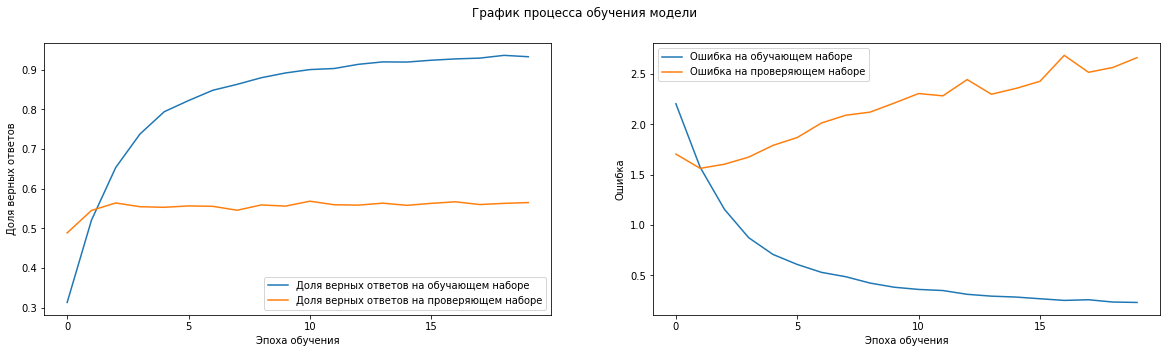

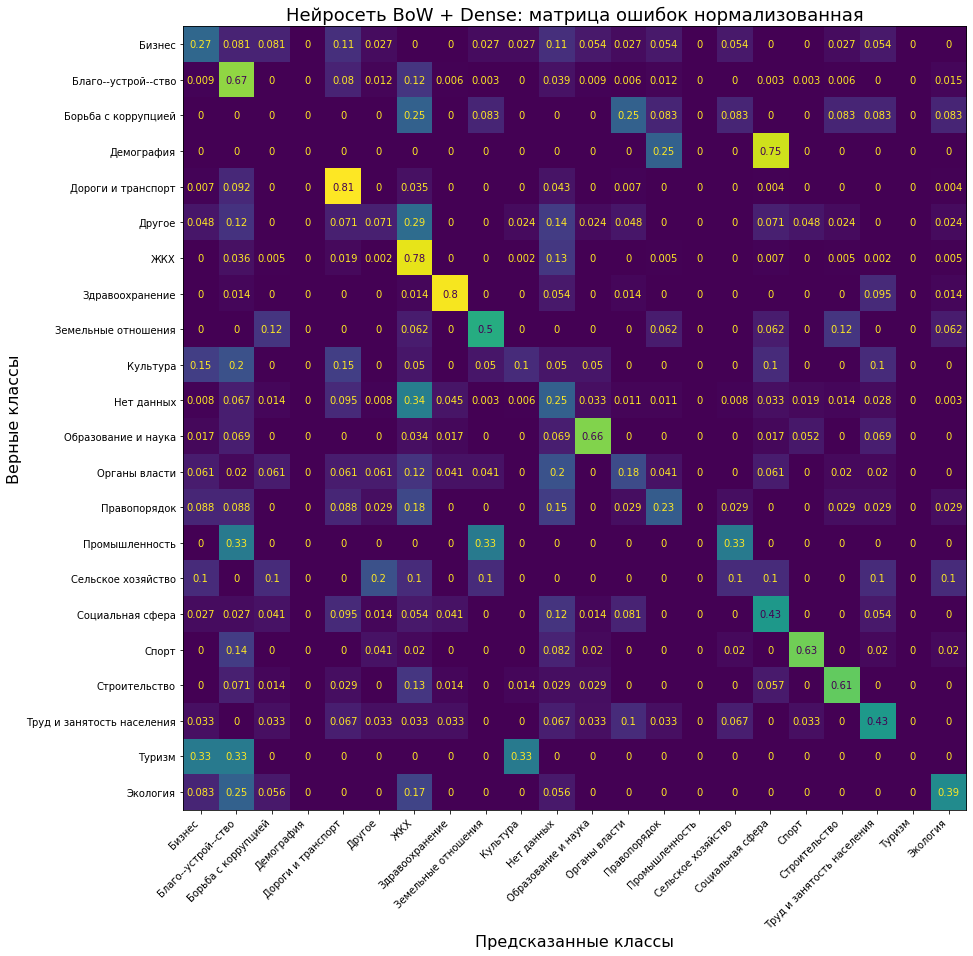

----------------------------------------------------------------------------------------------------
Нейросеть BoW + Dense
Класс Бизнес                27% сеть отнесла к классу Бизнес              

Средняя точность распознавания:  36%
Класс Благо­­устрой­­ство   67% сеть отнесла к классу Благо­­устрой­­ство 

Средняя точность распознавания:  36%
Класс Борьба с коррупцией   25% сеть отнесла к классу ЖКХ                 

Средняя точность распознавания:  36%
Класс Демография            75% сеть отнесла к классу Социальная сфера    

Средняя точность распознавания:  36%
Класс Дороги и транспорт    81% сеть отнесла к классу Дороги и транспорт  

Средняя точность распознавания:  36%
Класс Другое                29% сеть отнесла к классу ЖКХ                 

Средняя точность распознавания:  36%
Класс ЖКХ                   78% сеть отнесла к классу ЖКХ                 

Средняя точность распознавания:  36%
Класс Здравоохранение       80% сеть отнесла к классу Здравоохранение     

Средняя то

In [47]:
model_text_bow_dense = Sequential()
model_text_bow_dense.add(Dense(100, input_dim = VOCAB_SIZE, activation = 'relu'))
model_text_bow_dense.add(Dropout(0.4))
model_text_bow_dense.add(Dense(100, activation = 'relu'))
model_text_bow_dense.add(Dropout(0.4))
model_text_bow_dense.add(Dense(100, activation = 'relu'))
model_text_bow_dense.add(Dropout(0.4))
model_text_bow_dense.add(Dense(CLASS_COUNT, activation = 'softmax'))

compile_train_eval_model(model_text_bow_dense,
                        x_train_01, y_train,
                        x_test_01, y_test,
                        epochs = 20,
                        batch_size = 32,
                        cm_size = (16, 16),
                        class_labels = CLASS_LIST,
                        title = 'BoW + Dense')

# Embedding + Dense

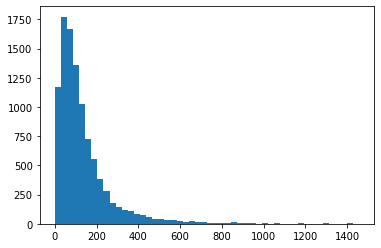

In [96]:
seq_len = [len(x) for x in x_data]
plt.hist(seq_len, 50)
plt.show()

In [97]:
seq_max_len = 400
x_train_clip = pad_sequences(x_train, maxlen = seq_max_len)
x_test_clip = pad_sequences(x_test, maxlen = seq_max_len)

print(x_train_clip.shape, x_test_clip.shape)

(8047, 400) (2012, 400)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 50)           1500000   
                                                                 
 dropout_10 (Dropout)        (None, 400, 50)           0         
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 64)                1280064   
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                      

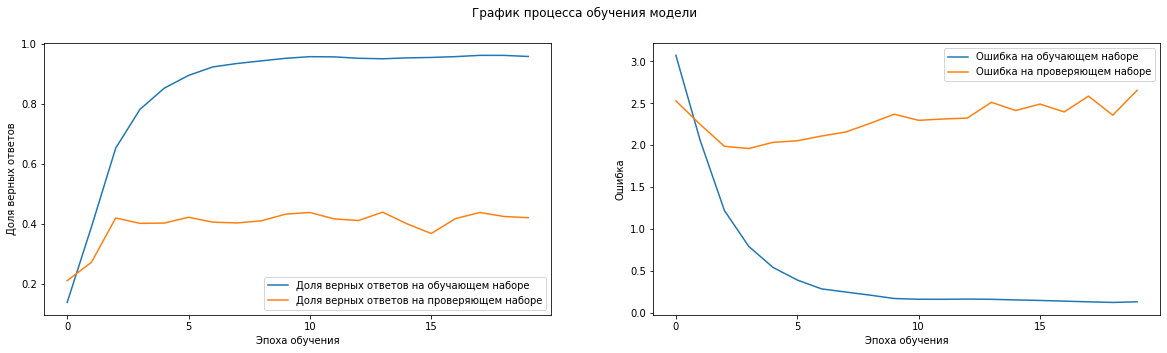

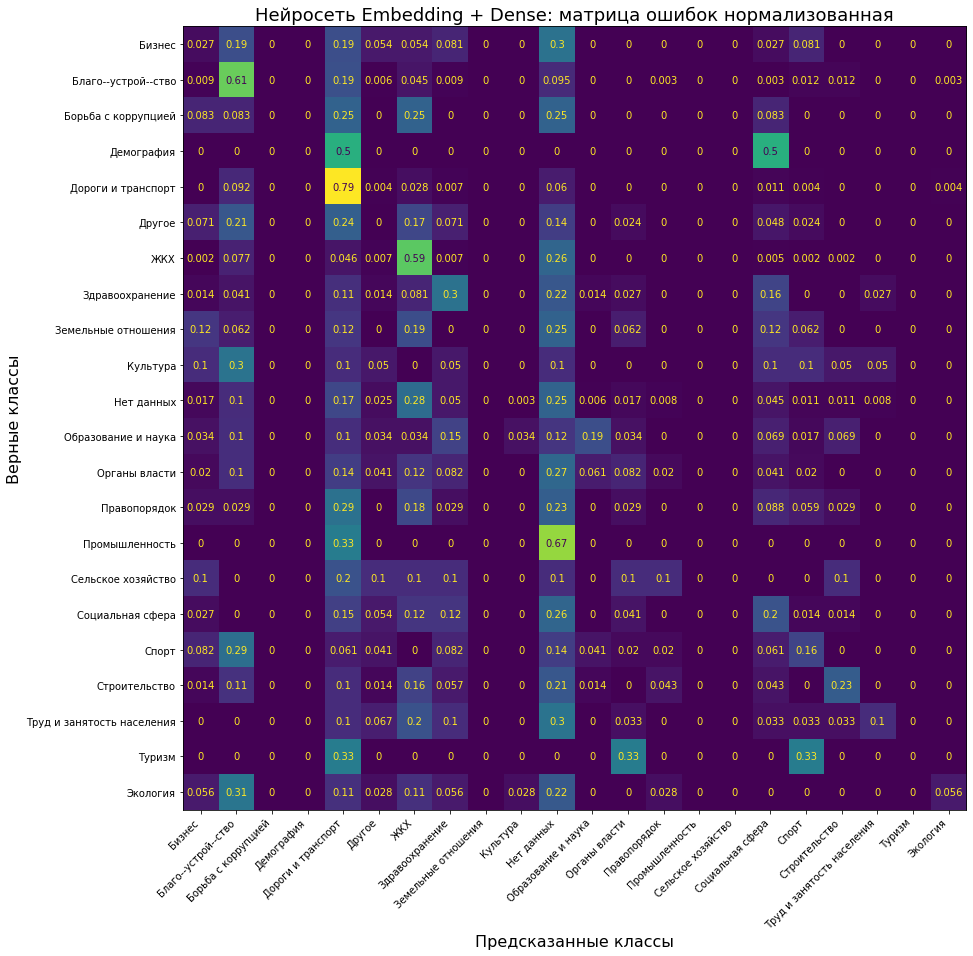

----------------------------------------------------------------------------------------------------
Нейросеть Embedding + Dense
Класс Бизнес                30% сеть отнесла к классу Нет данных          

Средняя точность распознавания:  16%
Класс Благо­­устрой­­ство   61% сеть отнесла к классу Благо­­устрой­­ство 

Средняя точность распознавания:  16%
Класс Борьба с коррупцией   25% сеть отнесла к классу Дороги и транспорт  

Средняя точность распознавания:  16%
Класс Демография            50% сеть отнесла к классу Дороги и транспорт  

Средняя точность распознавания:  16%
Класс Дороги и транспорт    79% сеть отнесла к классу Дороги и транспорт  

Средняя точность распознавания:  16%
Класс Другое                24% сеть отнесла к классу Дороги и транспорт  

Средняя точность распознавания:  16%
Класс ЖКХ                   59% сеть отнесла к классу ЖКХ                 

Средняя точность распознавания:  16%
Класс Здравоохранение       30% сеть отнесла к классу Здравоохранение     

Сред

In [48]:
model_text_emb_dense = Sequential()
model_text_emb_dense.add(Embedding(VOCAB_SIZE, 50, input_length = seq_max_len))
model_text_emb_dense.add(Dropout(0.4))
model_text_emb_dense.add(Flatten())
model_text_emb_dense.add(BatchNormalization())
model_text_emb_dense.add(Dense(64, activation = 'relu'))
model_text_emb_dense.add(Dropout(0.4))
model_text_emb_dense.add(BatchNormalization())
model_text_emb_dense.add(Dense(CLASS_COUNT, activation = 'softmax'))

compile_train_eval_model(model_text_emb_dense,
                        x_train_clip, y_train,
                        x_test_clip, y_test,
                        epochs = 20,
                        batch_size = 32,
                        cm_size = (16, 16),
                        class_labels = CLASS_LIST,
                        title = 'Embedding + Dense')

In [98]:
data_summary(df, CLASS_LIST)

Количество записей класса Бизнес : 187
Количество записей класса Благо­­устрой­­ство : 1686
Количество записей класса Борьба с коррупцией : 59
Количество записей класса Демография : 20
Количество записей класса Дороги и транспорт : 1411
Количество записей класса Другое : 208
Количество записей класса ЖКХ : 2063
Количество записей класса Здравоохранение : 368
Количество записей класса Земельные отношения : 80
Количество записей класса Культура : 100
Количество записей класса Нет данных : 1797
Количество записей класса Образование и наука : 290
Количество записей класса Органы власти : 244
Количество записей класса Правопорядок : 172
Количество записей класса Промышленность : 13
Количество записей класса Сельское хозяйство : 50
Количество записей класса Социальная сфера : 370
Количество записей класса Спорт : 246
Количество записей класса Строительство : 349
Количество записей класса Труд и занятость населения : 151
Количество записей класса Туризм : 15
Количество записей класса Экология

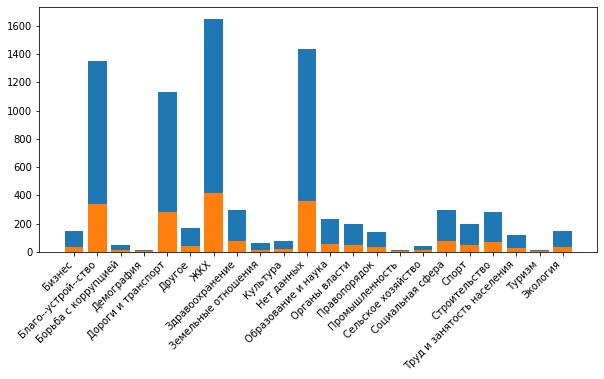

In [99]:
fig = plt.figure(figsize = (10, 5))
c_train = np.bincount(np.argmax(y_train, axis = 1))
c_test = np.bincount(np.argmax(y_test, axis = 1))
plt.bar(CLASS_LIST, c_train)
plt.bar(CLASS_LIST, c_test)
fig.autofmt_xdate(rotation = 45)
plt.show()

In [100]:
text_count_interval = [200, 400]

class_to_drop = ['Нет данных']
for cls in df.category.unique():
    if df[df.category == cls].shape[0] < text_count_interval[0]:
        class_to_drop.append(cls)
print(f'Удаляются классы {class_to_drop}')
del_mask = df.category.isin(class_to_drop)
#df = [~del_mask]

#for cls in df.category.unique():
    #df = df.drop(df[df.category == cls].index[text_count_interval[1]:])

Удаляются классы ['Нет данных', 'Культура', 'Демография', 'Бизнес', 'Экология', 'Правопорядок', 'Труд и занятость населения', 'Борьба с коррупцией', 'Промышленность', 'Сельское хозяйство', 'Земельные отношения', 'Туризм']


In [101]:
df

,text,category,theme
0,Здравствуйте. Подскажите пожалуйста можно ли с...,Дороги и транспорт,Запрос на льготы / субсидии
1,Подскажите пожалуйста имеют ли право не платит...,ЖКХ,Запрос юридической консультации
2,""" Спасибо Вам огромное за возобновление строит...",Строительство,Запрос юридической консультации
3,Проблема одна и общая стала в городе. Спорт. у...,Спорт,Недовольство общее
4,Некоторое время назад для школьников и студент...,Дороги и транспорт,Запрос на льготы / субсидии
...,...,...,...
10054,Единственная асфальтированная дорога в п. Заре...,Благо­­устрой­­ство,Нет данных
10055,УВАЖАЕМЫЙ ИГОРЬ ГЕОРГИЕВИЧ! В ПОСЕЛКЕ ЛЕВ ТОЛС...,Борьба с коррупцией,Нет данных
10056,Здравствуйте! 19 июня 2019 года затопило магаз...,ЖКХ,Нет данных
10057,Уважаемый! Помогите пожалуйста решить проблему...,ЖКХ,Нет данных


In [102]:
data_summary(df, df.category.unique())

Количество записей класса Дороги и транспорт : 1411
Количество записей класса ЖКХ : 2063
Количество записей класса Строительство : 349
Количество записей класса Спорт : 246
Количество записей класса Благо­­устрой­­ство : 1686
Количество записей класса Образование и наука : 290
Количество записей класса Культура : 100
Количество записей класса Демография : 20
Количество записей класса Социальная сфера : 370
Количество записей класса Другое : 208
Количество записей класса Бизнес : 187
Количество записей класса Здравоохранение : 368
Количество записей класса Органы власти : 244
Количество записей класса Экология : 180
Количество записей класса Правопорядок : 172
Количество записей класса Труд и занятость населения : 151
Количество записей класса Борьба с коррупцией : 59
Количество записей класса Промышленность : 13
Количество записей класса Сельское хозяйство : 50
Количество записей класса Земельные отношения : 80
Количество записей класса Туризм : 15
Количество записей класса Нет данных 

# GG Okay